## Nature Conservancy Fisheries Monitoring
### Supporting Automated Fish Classification to Help Maintain Ocean Biodiversity
#### Group 1: James Darmody, John Gao, Joanna Wang, Bryan Morgan

#### Project Description
The main goal of this project is to be able to detect which species of fish appears on a fishing boat, based on images captured from boat cameras of various angles.
Eight target categories are available in this dataset: Albacore tuna, Bigeye tuna, Yellowfin tuna, Mahi Mahi, Opah, Sharks, Other (meaning that there are fish present but not in the above categories), and No Fish (meaning that no fish is in the picture). Each image has only one fish category, except that there are sometimes very small fish in the pictures that are used as bait. 
The dataset was compiled by The Nature Conservancy in partnership with Satlink, Archipelago Marine Research, the Pacific Community, the Solomon Islands Ministry of Fisheries and Marine Resources, the Australia Fisheries Management Authority, and the governments of New Caledonia and Palau.

#### Data & Features
There are 3777 images in our training data set and 1000 images in our test set.
All of the images in our dataset are color images (RGB), and so all of the features are simply pixels (rows and columns) and channels.
One challenge is that there are images of many different sizes in the dataset, and these will have to be reshaped as part of pre-processing 


#### Algorithm & Hyperparameters
We will need to engage the power of deep learning using a convolutional neural network from the Keras package, using a TensorFlow backend to complete this classification.  The hyperparameters we will tune will include: the number of convolutional layers, the number of activation layers and type of activation used, the number of pooling layers and type of pooling used, the number of pixels and channels for each image (there are many different sizes in the data and all will need to be resized), the loss function, the kernel size, the optimizer, the type of padding and whether it will be used, whether dropout will be used, whether bias will be used, the number of epochs, and batch size.

#### Technical & Societal Objectives
The technical objective of this project will be to limit the multi-class logarithmic loss of our predictions on the test set once we have fitted a functioning convolutional neural network on the training data.
The societal objective will be to develop a workable solution that will help authorities deal with the scope of the problem of overfitting by classifying images from fishing boats using the power of machine learning.

### Loading Pacakges 
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

In [2]:
# Importing basic packages
import pandas as pd
import numpy as np
import glob
from scipy.misc import imread
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
%matplotlib inline

In [254]:
# Importing packages for deep learning
import keras
from tensorflow.keras import backend
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.ops.nn import leaky_relu
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

### Loading Training & Test Data
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

In [255]:
import warnings
warnings.filterwarnings('ignore')

# Setting up directory paths and labels for each class in the data
train_directory = '/Users/jamesdarmody/Documents/W207/Final/train/'
test_directory = '/Users/jamesdarmody/Documents/W207/Final/test_stg1/'
fish_labels = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

# Training Data loading
train_files = sorted(glob.glob('/Users/jamesdarmody/Documents/W207/Final/train/*/*.jpg'), 
                     key=lambda x: np.random.random())
train = np.array([imread(img) for img in train_files])
print('Length of train {}'.format(len(train)))

# Data loading Test
test_files = sorted(glob.glob('/Users/jamesdarmody/Documents/W207/Final/test_stg1/*.jpg'), 
                    key=lambda x: np.random.random())
test = np.array([imread(img) for img in test_files])
print('Length of test {}'.format(len(test)))

Length of train 3777
Length of test 1000


### Loading Sample Images From Data
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

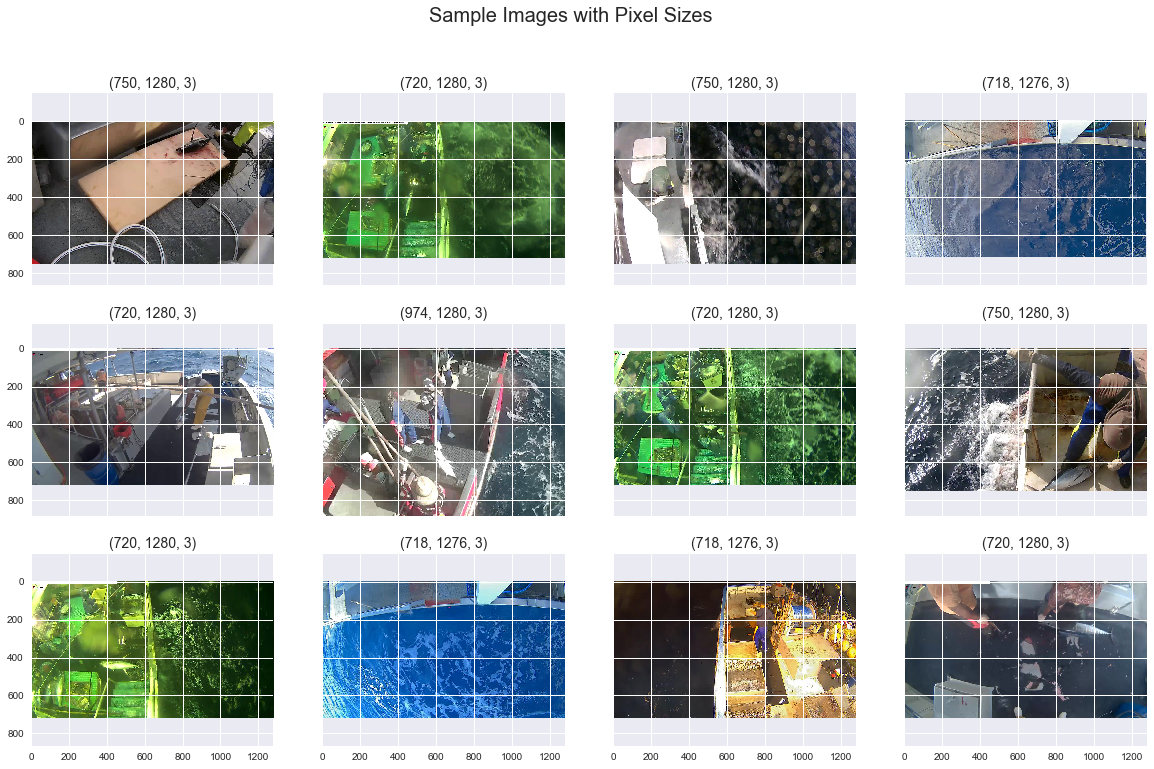

In [258]:
# Function to show a dozen sample images from the data
def sample_dozen(imgs, title):
    random_image_selection = [imgs[np.random.choice(len(imgs))] for _ in range(12)]
    _, ax = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(20, 12))
    plt.suptitle(title, size=20)
    for i, img in enumerate(random_image_selection):
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(img.shape, fontsize=14)
        ax[i // 4, i % 4].tick_params(axis='both', which='major', labelsize=10)
        
sample_dozen(train,  "Sample Images with Pixel Sizes")

### Exploratory Data Analysis
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

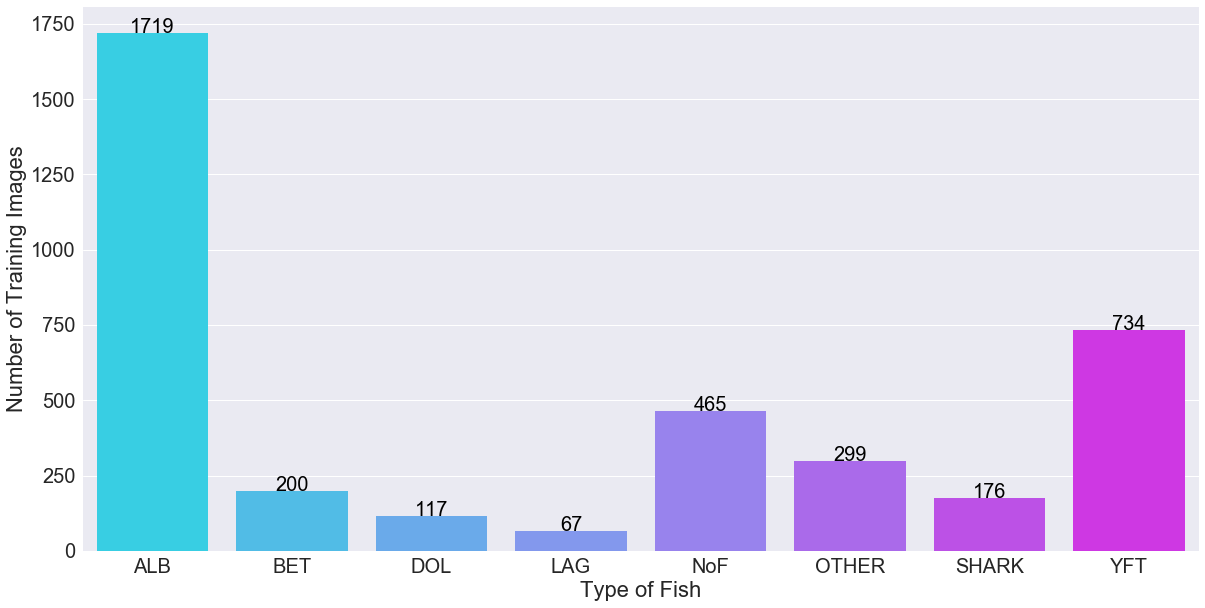

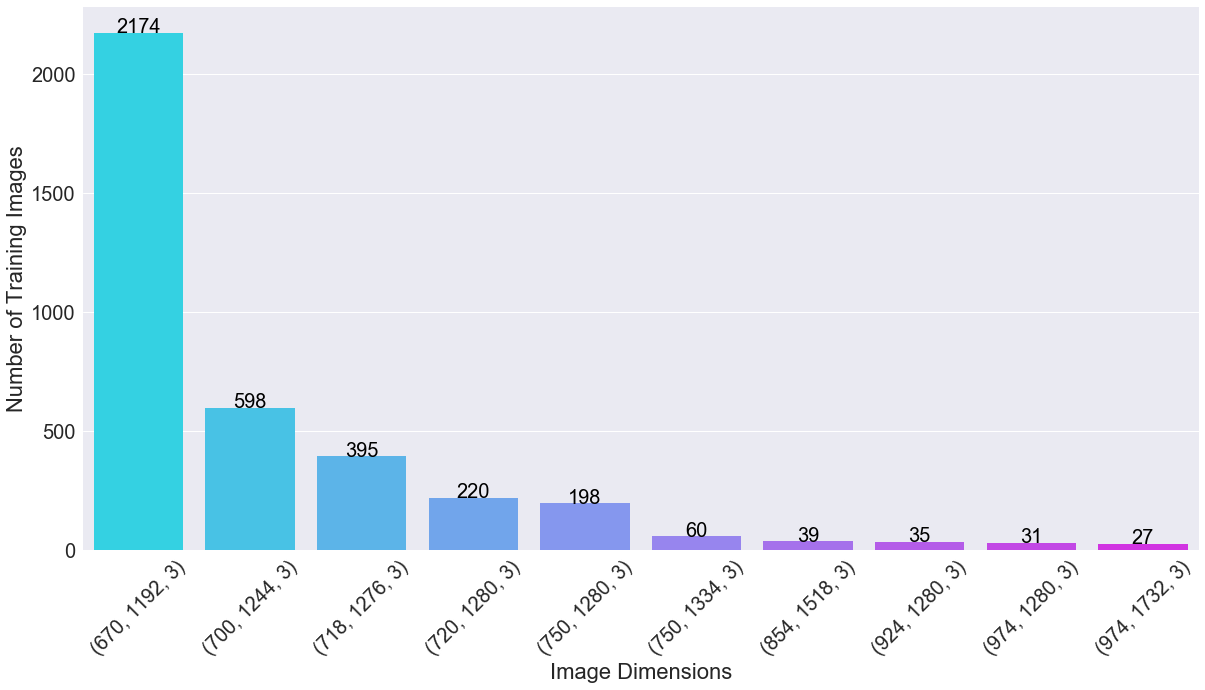

In [289]:
# Create a bar chart showing number of training images of each type
sns.set_style('darkgrid')
sns.set(font_scale=2)
plt.figure(figsize=(20,10))

total_images = []
for fish in fish_labels:
    fish_species = get_images(fish)
    total_images.append(len(fish_species))
ax_type = sns.barplot(fish_labels, total_images, palette="cool")
ax_type.set(xlabel='Type of Fish', ylabel='Number of Training Images')
for position, number in enumerate(total_images):
    ax_type.text(x=position, y=number, s=number, color='black', ha="center", fontsize=20)
    
    
# Create bar chart showing number of training images of each size 
shapes = np.array([str(img.shape) for img in train])
shape_counts = pd.Series(shapes).value_counts()
sns.set_style('darkgrid')
sns.set(font_scale=2)
plt.figure(figsize=(20,10))

ax_size = sns.barplot(np.unique(shapes), pd.Series(shapes).value_counts(), palette='cool')
ax_size.set(xlabel='Image Dimensions', ylabel='Number of Training Images')
for position, number in enumerate(shape_counts):
    ax_size.text(x=position, y=number, s=number, color='black', ha="center", fontsize=20)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

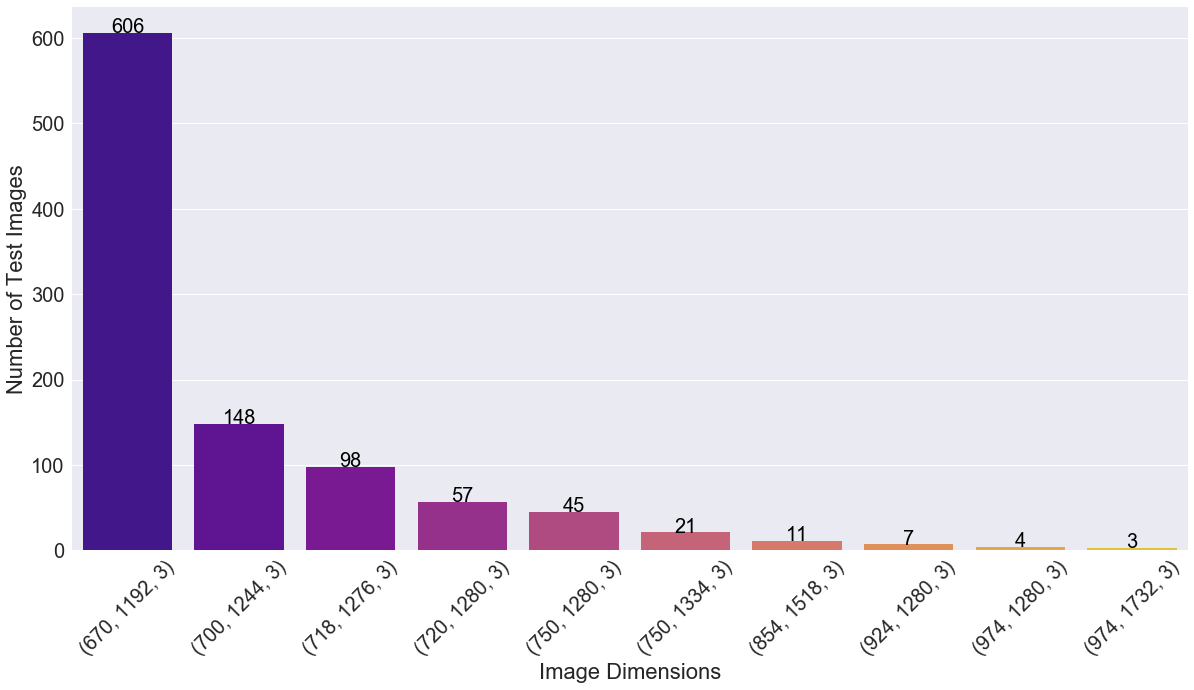

In [293]:
# Create bar chart showing number of test images of each type
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
sns.set(font_scale=2)

shapes_test = np.array([str(img.shape) for img in test])
shapes_test_counts = pd.Series(shapes_test).value_counts()
ax_test_size = sns.barplot(np.unique(shapes_test), pd.Series(shapes_test).value_counts(),
                          palette='plasma')
ax_test_size.set(xlabel='Image Dimensions', ylabel='Number of Test Images')
for position, number in enumerate(shapes_test_counts):
    ax_test_size.text(x=position, y=number, s=number, color='black', ha="center", fontsize=20)
plt.xticks(rotation=45)

### Preprocessing Data
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

In [319]:
# Define function for reading image files with computer vision package

def read_image(src, columns, rows):
    image = cv2.imread(src, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (columns, rows), interpolation=cv2.INTER_LANCZOS4)
    return(image)

# All images for convolutional neural network must be same size
# Specify pixels and channels - larger data means higher accuracy and slower speed 
# A channel is the grayscale image of same size as a color image made of one primary color
# Color images have three channels (red, green, and blue)

column_pixels=135
row_pixels=75
channels=3

# Loop through files to get lists of all training/test files and all labels associated

total_train_files = []
total_y = []

for fish in fish_labels:
    total_files = get_images(fish)
    total_train_files.extend(total_files)
    y_fish = np.tile(fish, len(total_files))
    total_y.extend(y_fish)
    
y_array = np.array(total_y)
print("Test data shape prior to one-hot encoding: {}".format(y_array.shape))
train_y_one_hot = LabelEncoder().fit_transform(y_array)
train_y_one_hot = np_utils.to_categorical(train_y_one_hot)
print("Test data shape after one-hot encoding: {}".format(train_y_one_hot.shape))

# Define the desired shape of the array of the training files
total_X = np.ndarray((len(total_train_files), row_pixels, column_pixels, channels), dtype=np.uint8)
# Deposit the data into this array, leveraging the function for reading image files
for i, image in enumerate(total_train_files):
    total_X[i] = read_image(train_directory+image, column_pixels, row_pixels)
    
print("Training data shape: {}".format(total_X.shape))

Test data shape prior to one-hot encoding: (3777,)
Test data shape after one-hot encoding: (3777, 8)
Training data shape: (3777, 75, 135, 3)


In [320]:
# Splitting training data from test data
X_train, X_test, y_train, y_test = train_test_split(total_X, 
train_y_one_hot, random_state=0, stratify=train_y_one_hot, test_size=0.2)

# Converting data from int8 to float32 for convolutional neural network model
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

### Establishing a Baseline
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

Baseline Accuracy: 0.1204
##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##
Classification Report for Baseline Accuracy
              precision    recall  f1-score   support

           0       0.43      0.42      0.42       344
           1       0.04      0.05      0.04        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        13
           4       0.14      0.14      0.14        93
           5       0.10      0.07      0.08        60
           6       0.00      0.00      0.00        35
           7       0.23      0.24      0.24       147

   micro avg       0.27      0.26      0.27       756
   macro avg       0.12      0.11      0.12       756
weighted avg       0.27      0.26      0.27       756
 samples avg       0.19      0.26      0.21       756

##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##
Confusion Matrix for Baseline Accuracy


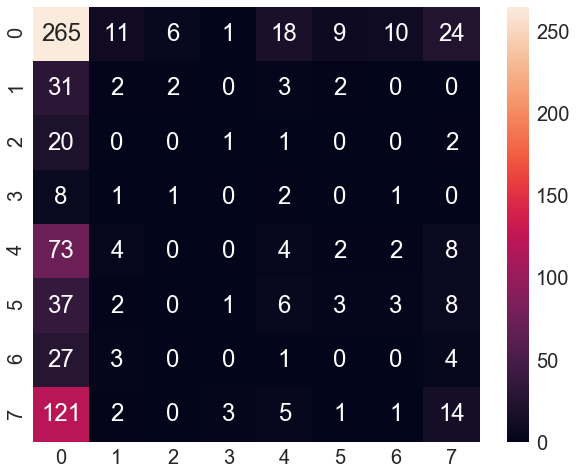

In [321]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

dummy = DummyClassifier(strategy='stratified', random_state=0)
baseline_fitted = dummy.fit(X_train, y_train)
baseline_predict = dummy.predict(X_test)
baseline_score = dummy.score(X_test, y_test)
print("Baseline Accuracy: {}".format(round(baseline_score,4)))
print('##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##')

print('Classification Report for Baseline Accuracy')
print(classification_report(y_test, baseline_predict))

print('##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##')
print('Confusion Matrix for Baseline Accuracy')
baseline_confusion = confusion_matrix(y_test.argmax(axis=1), 
                       baseline_predict.argmax(axis=1))
plt.figure(figsize=(10,8))
sns.heatmap(baseline_confusion, annot=True, fmt="d");

#### Baseline Discussion
The baseline is able to correcty classify with approximately 12% accuracy.  Given that we have 8 classes in our data, this is almost exactly on a par with pure random chance, so the goal of our convolutional neural network will be to improve upon this.  In addition, in order to prevent overfishing, false negatives are far more harmful than false positives.
For instance, if an algorithm wrongly identifies a boat as overfishing, it will be a minor inconvenience for the boat in question to show their catch to authorities and resolve the issue.  However, a false negative would allow a boat to get away with overfishing, and therefore this model should seek to maximize recall.

### Building the Model
--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##--##

In [322]:
# build the model
def center_normalize(x):
    return (x - K.mean(x)) / K.std(x)

fish_model = Sequential()

fish_model.add(Activation(activation=center_normalize, input_shape=(row_pixels, 
                                                                    column_pixels, channels)))
fish_model.add(Activation('relu'))
fish_model.add(Conv2D(32,kernel_size=(3,3), activation='relu', padding='same', use_bias=True))

fish_model.add(Activation('relu'))
fish_model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
fish_model.add(MaxPooling2D(pool_size=(2,2)))

fish_model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
fish_model.add(MaxPooling2D(pool_size=(2,2)))

fish_model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
fish_model.add(MaxPooling2D(pool_size=(2,2)))

fish_model.add(Flatten())
fish_model.add(Dense(256, activation='relu'))
fish_model.add(Dense(8, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto')

In [323]:
# dropouts, average pools, channels to zero, or downsample pixels, or crop - central crop, tf-record (pre-packaging of images in tensor flow), relu, convolutional, relu, then the rest of them - decrease by factor of 4
# first two layers relu after, no pooling, then do pooling but no relu after

In [324]:
fish_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adadelta',
                   metrics=['accuracy'])

In [325]:
overfish = fish_model.fit(X_train, y_train, batch_size=64, epochs=10,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping])

Train on 2416 samples, validate on 605 samples
Epoch 1/10
2416/2416 [==============================] - 160s 66ms/step - loss: 1.7178 - acc: 0.4313 - val_loss: 1.3822 - val_acc: 0.4876
Epoch 2/10
2416/2416 [==============================] - 171s 71ms/step - loss: 1.2209 - acc: 0.5853 - val_loss: 0.9937 - val_acc: 0.6463
Epoch 3/10
2416/2416 [==============================] - 171s 71ms/step - loss: 0.8189 - acc: 0.7194 - val_loss: 0.6843 - val_acc: 0.7339
Epoch 4/10
2416/2416 [==============================] - 156s 65ms/step - loss: 0.5082 - acc: 0.8286 - val_loss: 0.6698 - val_acc: 0.8033
Epoch 5/10
2416/2416 [==============================] - 151s 62ms/step - loss: 0.2550 - acc: 0.9164 - val_loss: 0.3332 - val_acc: 0.9091
Epoch 6/10
2416/2416 [==============================] - 150s 62ms/step - loss: 0.1374 - acc: 0.9561 - val_loss: 0.3552 - val_acc: 0.9140
Epoch 00006: early stopping


In [326]:
fish_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_20 (Activation)   (None, 75, 135, 3)        0         
_________________________________________________________________
activation_21 (Activation)   (None, 75, 135, 3)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 75, 135, 32)       896       
_________________________________________________________________
activation_22 (Activation)   (None, 75, 135, 32)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 75, 135, 64)       18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 37, 67, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 37, 67, 128)       73856     
__________

In [327]:
prediction = fish_model.predict(X_test, verbose=1)
print("Validation Log Loss: {}".format(log_loss(y_test, prediction)))

756/756 [==============================] - 19s 25ms/step
Validation Log Loss: 0.24316342779159475


In [328]:
prediction_max = np.argmax(prediction, axis=1)
y_test_max = np.argmax(y_test, axis=1)
print('Classification Report for Model Accuracy')
print(classification_report(y_test_max, prediction_max))

Classification Report for Model Accuracy
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       344
           1       0.97      0.93      0.95        40
           2       1.00      0.88      0.93        24
           3       1.00      1.00      1.00        13
           4       0.96      0.91      0.93        93
           5       0.88      0.97      0.92        60
           6       0.97      0.89      0.93        35
           7       0.94      0.89      0.92       147

   micro avg       0.93      0.93      0.93       756
   macro avg       0.96      0.93      0.94       756
weighted avg       0.94      0.93      0.93       756



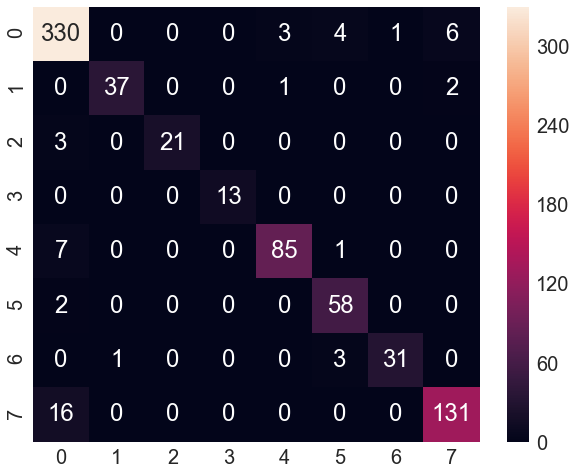

In [329]:
validation_confusion = confusion_matrix(y_test_max, prediction_max)
plt.figure(figsize=(10,8))
sns.heatmap(validation_confusion, annot=True, fmt="d");

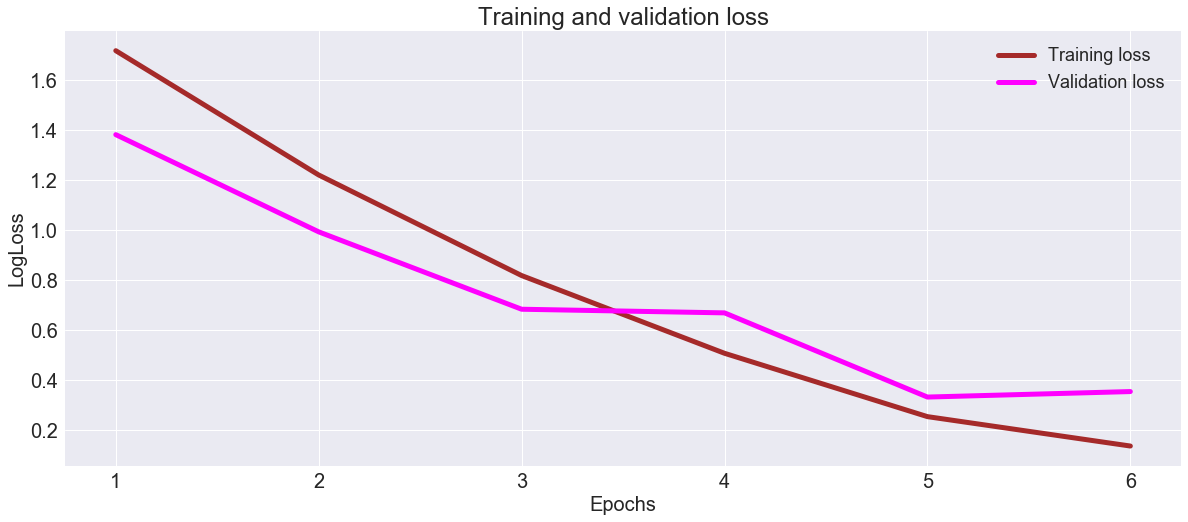

In [330]:
# setting up a plot for logloss versus epochs

validation_figure, validation_plot = plt.subplots(figsize=(20,8))
loss = overfish.history['loss']
val_loss = overfish.history['val_loss']
epochs = range(1, len(loss) + 1)
validation_plot.plot(epochs, loss, color='brown', label='Training loss', linewidth=5)
validation_plot.plot(epochs, val_loss, color='magenta', label='Validation loss', linewidth=5)
plt.title('Training and validation loss', fontsize=24)
validation_plot.set_xlabel('Epochs', fontsize=20)
validation_plot.set_ylabel('LogLoss', fontsize=20)
validation_plot.legend(fontsize=18)

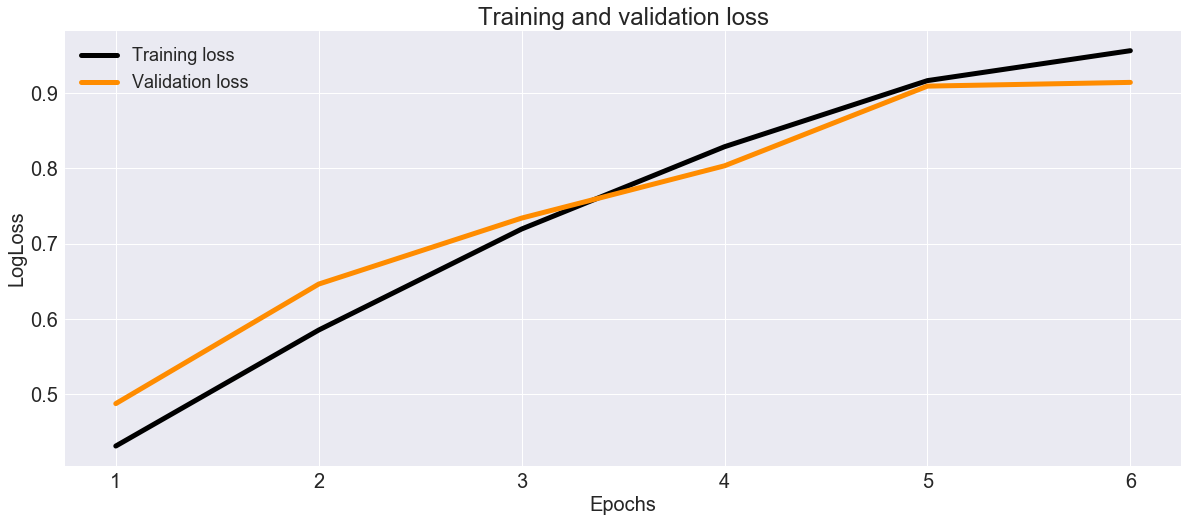

In [331]:
# setting up a plot for logloss versus epochs

accuracy_figure, accuracy_plot = plt.subplots(figsize=(20,8))
accuracy = overfish.history['acc']
val_accuracy = overfish.history['val_acc']
epochs = range(1, len(loss) + 1)
accuracy_plot.plot(epochs, accuracy, color='black', label='Training loss', linewidth=5)
accuracy_plot.plot(epochs, val_accuracy, color='darkorange', label='Validation loss', linewidth=5)
plt.title('Training and validation loss', fontsize=24)
accuracy_plot.set_xlabel('Epochs', fontsize=20)
accuracy_plot.set_ylabel('LogLoss', fontsize=20)
accuracy_plot.legend(fontsize=18)

In [221]:
layer_outputs = [layer.output for layer in fish_model.layers]
activation_model = Model(inputs=fish_model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[16].reshape(1,90,160,3))
 
def display_activation(activations, col_size, row_size, act_index, suptitle): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    fig.suptitle(suptitle, fontsize=20)
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='seismic')
            ax[row][col].tick_params(axis='both', which='major', labelsize=10)
            activation_index += 1

In [220]:
layer_outputs

[<tf.Tensor 'activation_6/truediv:0' shape=(?, 90, 160, 3) dtype=float32>,
 <tf.Tensor 'activation_7/Relu:0' shape=(?, 90, 160, 3) dtype=float32>,
 <tf.Tensor 'conv2d_16/Relu:0' shape=(?, 90, 160, 32) dtype=float32>,
 <tf.Tensor 'activation_8/Relu:0' shape=(?, 90, 160, 32) dtype=float32>,
 <tf.Tensor 'conv2d_17/Relu:0' shape=(?, 90, 160, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_15/MaxPool:0' shape=(?, 45, 80, 64) dtype=float32>,
 <tf.Tensor 'conv2d_18/Relu:0' shape=(?, 45, 80, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_16/MaxPool:0' shape=(?, 22, 40, 128) dtype=float32>,
 <tf.Tensor 'conv2d_19/Relu:0' shape=(?, 22, 40, 256) dtype=float32>,
 <tf.Tensor 'max_pooling2d_17/MaxPool:0' shape=(?, 11, 20, 256) dtype=float32>,
 <tf.Tensor 'flatten_4/Reshape:0' shape=(?, 56320) dtype=float32>,
 <tf.Tensor 'dense_8/Relu:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'dropout_2/cond/Merge:0' shape=(?, 256) dtype=float32>,
 <tf.Tensor 'dense_9/Softmax:0' shape=(?, 8) dtype=float32>,
 <tf.

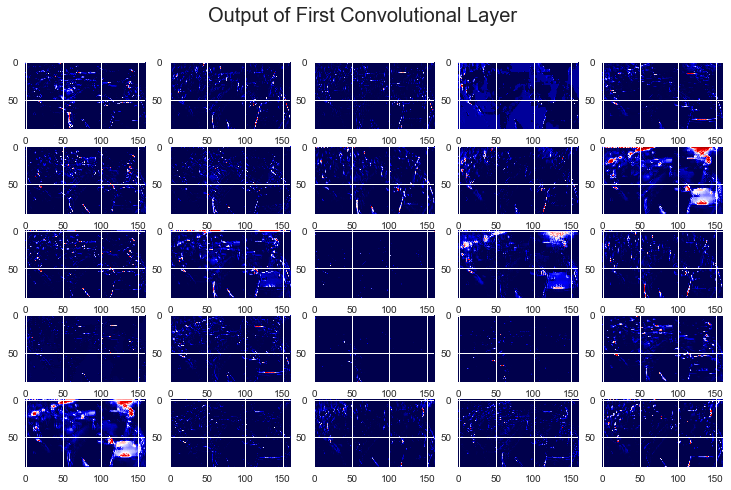

In [222]:
display_activation(activations, 5, 5, 2, "Output of First Convolutional Layer")

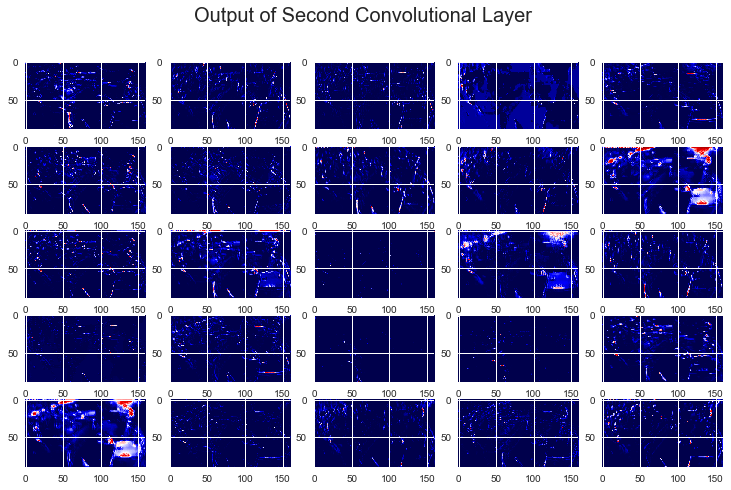

In [225]:
display_activation(activations, 5, 5, 3, "Output of Second Convolutional Layer")

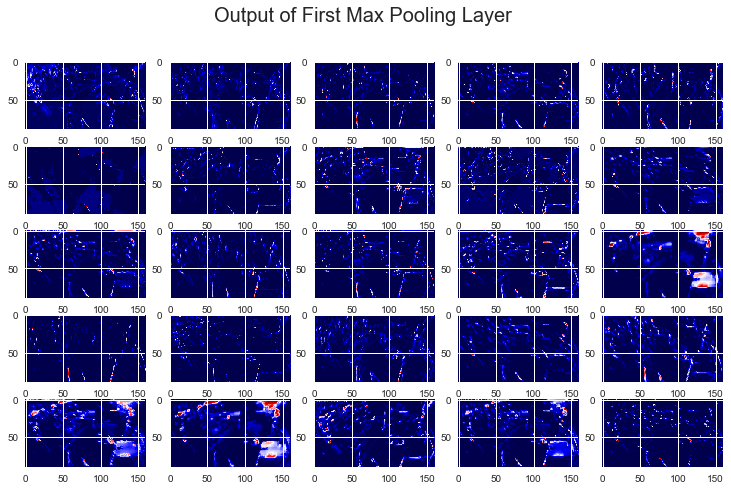

In [226]:
display_activation(activations, 5, 5, 4, "Output of First Max Pooling Layer")

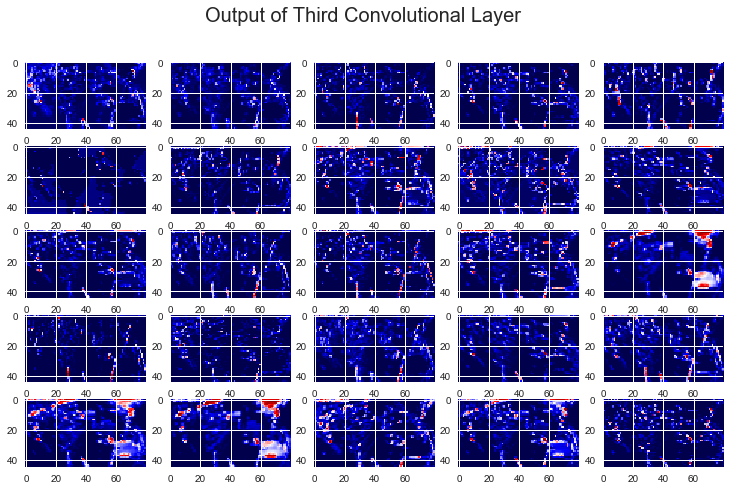

In [227]:
display_activation(activations, 5, 5, 5, "Output of Third Convolutional Layer")

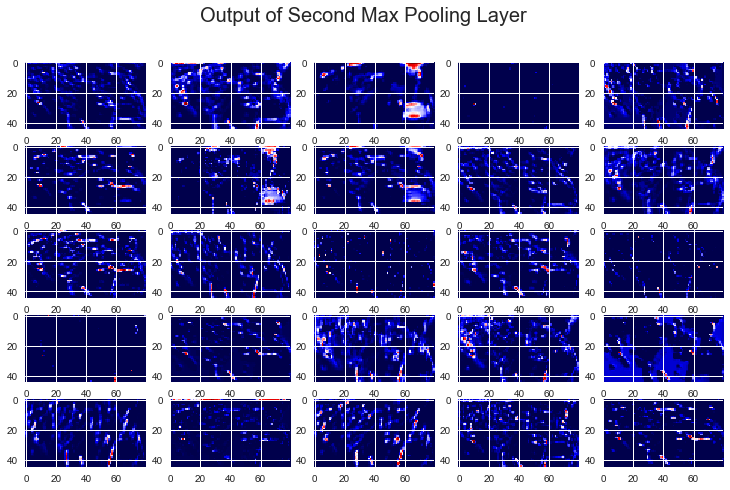

In [228]:
display_activation(activations, 5, 5, 6, "Output of Second Max Pooling Layer")

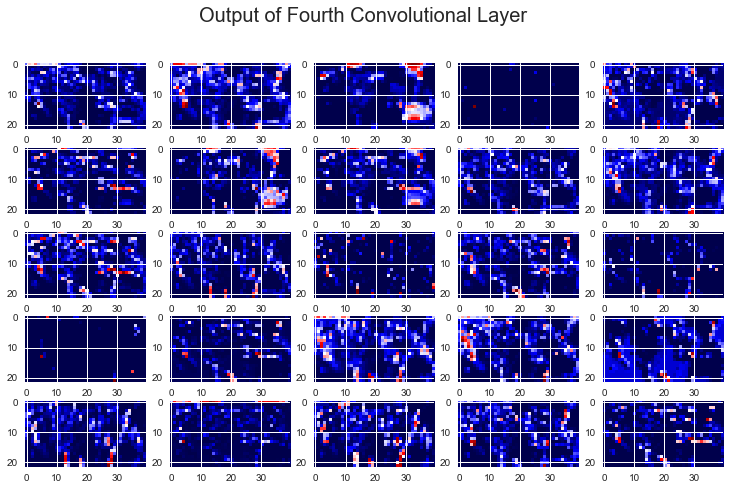

In [229]:
display_activation(activations, 5, 5, 7, "Output of Fourth Convolutional Layer")

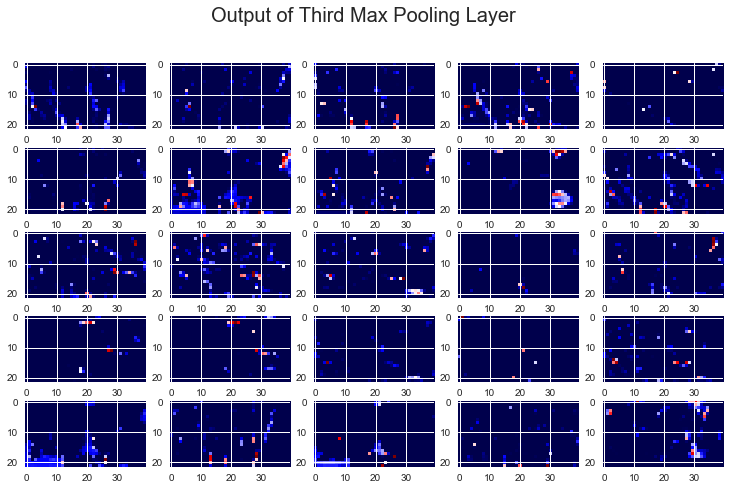

In [230]:
display_activation(activations, 5, 5, 8, "Output of Third Max Pooling Layer")

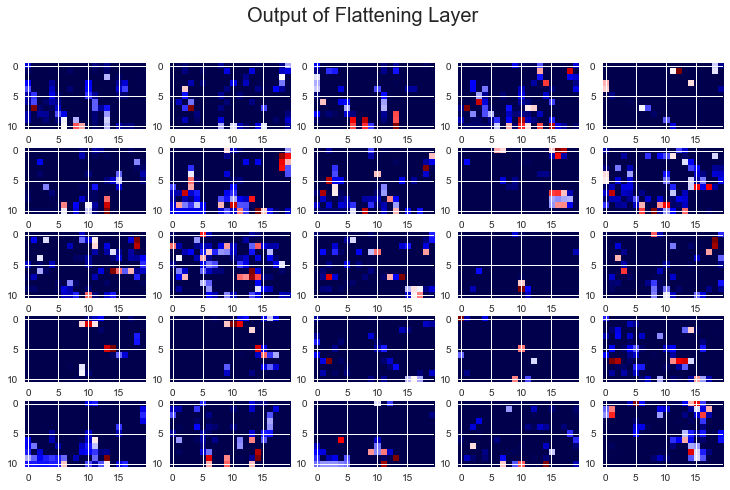

In [318]:
display_activation(activations, 5, 5, 9, "Output of Flattening Layer")

In [332]:
# Further suggestions
# Average vs. Max pools, Crop images, tfrecord (pre-packaging of images in tensor flow)
# Pretty matplotlib packaging of classification report
# Qualitative explanation of hyperparameters